In [1]:
import os
import os.path
from os import path
import time
import datetime

import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
# import geoplot as gplt

import plotnine
from plotnine import *
# set the plotnine figure size
plotnine.options.figure_size = (8, 6)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sodapy import Socrata
import json
import matplotlib.pyplot as plt
import folium
from IPython.display import display
import ipywidgets as wg

import warnings
warnings.filterwarnings('ignore')

# predictive model libraries:

import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split, cross_val_score

# PCA - Dimension Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import BallTree
# All valid metrics:
# BallTree.valid_metrics

DATASET_ID = {
"CarCrashes": "h9gi-nx95",
"LiveTraffic": "i4gi-tjb9"
}

FIG_WIDTH = 16
FIG_HEIGHT = 9

# sets timezone 
os.environ['TZ'] = "America/New_York"
time.tzset()

# import my own project files 
from Open_Data import * # class definition
from all_functions import * # helper functions
from reg_func import * # regressor optimization functions

In [2]:
# MyCrashes = Crashes("CarCrashes", 10000)
# MyCrashes.static_map()

# Instantiate Objects

MyTraffic = RTraffic("LiveTraffic", 10000)
MyTraffic.get_polylines()
# MyTraffic.display_folium()

all_links = list(MyTraffic.pol_df["names"].unique())
all_boros = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]

In [3]:
# make street names and boroughs categorical data
# and extract categorical code (for predictions)

MyTraffic.pol_df.names = pd.Categorical(MyTraffic.pol_df.names)
MyTraffic.pol_df['names_code'] = MyTraffic.pol_df.names.cat.codes

MyTraffic.pol_df.boro = pd.Categorical(MyTraffic.pol_df.boro)
MyTraffic.pol_df['boro_code'] = MyTraffic.pol_df.boro.cat.codes


# make the speed and time col vars numeric (apply float)

MyTraffic.pol_df["rou_speed"] = MyTraffic.pol_df["rou_speed"].apply(float)
MyTraffic.pol_df["tr_time"] = MyTraffic.pol_df["tr_time"].apply(float)


# convert time (timestamp) to a np.float64 object

MyTraffic.pol_df["time_float"] = MyTraffic.pol_df["time_s"].apply(lambda x: np.datetime64(x).astype("float"))

# NOTE: this_time = np.datetime64('2018-04-01T15:30:00').astype("float")
# revert_date = np.datetime64(datetime.datetime.utcfromtimestamp(this_time))

# Alt: convert time (timestamp) to a Pandas Datetime object
# MyTraffic.pol_df["time_s"] = pd.to_datetime(MyTraffic.pol_df["time_s"], format = "%Y-%m-%dT%H:%M:%S")

# how to parse string into datetime object:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes


# calculate the distance (travel distance) for each recorded street (one end point to another)

MyTraffic.pol_df["tr_dist"] = MyTraffic.pol_df["geometry"].apply(lambda x: float(x.length))


# drop all recorded speed of 0 mile per hour or a travel time of 0 seconds
# (invalid observation - based on realistic life intuition)
# WHAT IS MISSING (EXCLUDED DUE TO INVALID OBS)

MyTraffic.pol_df = MyTraffic.pol_df[MyTraffic.pol_df["rou_speed"] != 0]
MyTraffic.pol_df = MyTraffic.pol_df[MyTraffic.pol_df["tr_time"] != 0]

In [4]:
MyTraffic.pol_df

,names,rou_speed,time_s,boro,tr_time,geometry,names_code,boro_code,time_float,tr_dist
0,11th ave n ganservoort - 12th ave @ 40th st,0.62,2021-12-04T14:33:10.000,Manhattan,4587.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638628e+12,0.021501
1,11th ave n ganservoort - 12th ave @ 40th st,0.62,2021-12-04T14:59:10.000,Manhattan,4757.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638630e+12,0.021501
2,11th ave n ganservoort - 12th ave @ 40th st,1.24,2021-12-04T11:23:10.000,Manhattan,2943.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638617e+12,0.021501
3,11th ave n ganservoort - 12th ave @ 40th st,1.24,2021-12-04T12:08:11.000,Manhattan,2947.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638620e+12,0.021501
4,11th ave n ganservoort - 12th ave @ 40th st,1.24,2021-12-04T12:38:11.000,Manhattan,3027.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638621e+12,0.021501
...,...,...,...,...,...,...,...,...,...,...
9995,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.19,2021-12-04T10:13:12.000,Queens,106.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638613e+12,0.011665
9996,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.19,2021-12-04T10:23:10.000,Queens,105.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638613e+12,0.011665
9997,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.19,2021-12-04T11:13:11.000,Queens,106.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638616e+12,0.011665
9998,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.81,2021-12-04T10:03:11.000,Queens,105.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638612e+12,0.011665


In [5]:
speed_on_t_dist = smf.ols('rou_speed ~ tr_time + tr_dist', MyTraffic.pol_df).fit()
speed_on_t_dist.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rou_speed   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     2752.
Date:                Sat, 04 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:33:44   Log-Likelihood:                -36282.
No. Observations:                9210   AIC:                         7.257e+04
Df Residuals:                    9207   BIC:                         7.259e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9063      0.345    115.563      0.000      39.229      40.583
tr_time       -0.0228      0.000    -73.303      0.000      -0.023      -0.022
tr_dist      179.5197     17.056     10.525      0.000     146.086     212.953
==============================================================================
Omnibus:                     1031.697   Durbin-Watson:                   0.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6909.087
Skew:                           0.320   Prob(JB):                         0.00
Kurtosis:                       7.195   Cond. No.                     6.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Distance can be calculated using longitude and latitude of start/end points (known)
- Travel speed can be estimated using the known distance and the predicted travel time

Hence: focus on predicting **travel time**

In [6]:
# what are the obs with the maximum travel time?
MyTraffic.pol_df[MyTraffic.pol_df['tr_time'] == MyTraffic.pol_df['tr_time'].max()]

,names,rou_speed,time_s,boro,tr_time,geometry,names_code,boro_code,time_float,tr_dist
2915,CBE W L/LE V AMSTERDAM AVE - I 95 S LOC LNS,0.62,2021-12-04T14:14:03.000,Bronx,8168.0,"LINESTRING (-73.93188 40.84667, -73.93350 40.8...",36,0,1.638627e+12,0.030932
2916,CBE W L/LE V AMSTERDAM AVE - I 95 S LOC LNS,0.62,2021-12-04T14:19:03.000,Bronx,8168.0,"LINESTRING (-73.93188 40.84667, -73.93350 40.8...",36,0,1.638628e+12,0.030932


In [7]:
ols_mod_1 = smf.ols('rou_speed ~ names_code + boro_code + time_float + tr_time + tr_dist', MyTraffic.pol_df).fit()
ols_mod_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rou_speed   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     1825.
Date:                Sat, 04 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:33:44   Log-Likelihood:                -35751.
No. Observations:                9210   AIC:                         7.151e+04
Df Residuals:                    9205   BIC:                         7.155e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.538e-05   3.48e-06    -10.170      0.000   -4.22e-05   -2.86e-05
names_code     0.0319      0.004      7.824      0.000       0.024       0.040
boro_code      2.4766      0.108     22.998      0.000       2.265       2.688
time_float  1.966e-11   2.47e-13     79.460      0.000    1.92e-11    2.01e-11
tr_time       -0.0213      0.000    -71.583      0.000      -0.022      -0.021
tr_dist      163.8048     16.109     10.168      0.000     132.227     195.382
==============================================================================
Omnibus:                     1291.784   Durbin-Watson:                   0.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9649.932
Skew:                           0.452   Prob(JB):                         0.00
Kurtosis:                       7.932   Cond. No.                     3.27e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+17. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

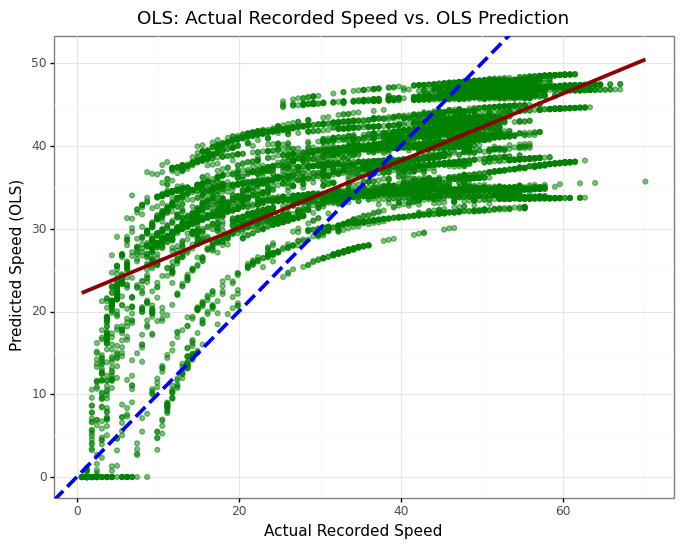

<ggplot: (313661191)>

In [8]:
# make the col for the OLS predicted values
MyTraffic.pol_df['pred_ols_1'] = ols_mod_1.predict()

# if predicted value is negative: force it to be zero
MyTraffic.pol_df['pred_ols_1'].loc[MyTraffic.pol_df['pred_ols_1'] < 0] = 0

(ggplot(MyTraffic.pol_df[['rou_speed', 'pred_ols_1']], aes(x = 'rou_speed', y = 'pred_ols_1'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'pred_ols_1'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Recorded Speed")
+ ylab("Predicted Speed (OLS)")
+ ggtitle("OLS: Actual Recorded Speed vs. OLS Prediction")
+ theme_bw())

In [9]:
ols_mod_2 = smf.ols('tr_time ~ names_code + boro_code + time_float + tr_dist', MyTraffic.pol_df).fit()
ols_mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tr_time   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     97.86
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           2.39e-62
Time:                        19:33:46   Log-Likelihood:                -68484.
No. Observations:                9210   AIC:                         1.370e+05
Df Residuals:                    9206   BIC:                         1.370e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.135e-05   9.17e-05     -0.778      0.437      -0.000       0.000
names_code    -1.7790      0.141    -12.577      0.000      -2.056      -1.502
boro_code     -9.8626      3.763     -2.621      0.009     -17.239      -2.486
time_float  2.608e-10   8.21e-12     31.751      0.000    2.45e-10    2.77e-10
tr_dist     -437.6511    563.082     -0.777      0.437   -1541.417     666.115
==============================================================================
Omnibus:                    10527.187   Durbin-Watson:                   0.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1459236.800
Skew:                           5.849   Prob(JB):                         0.00
Kurtosis:                      63.545   Cond. No.                     3.26e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+17. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

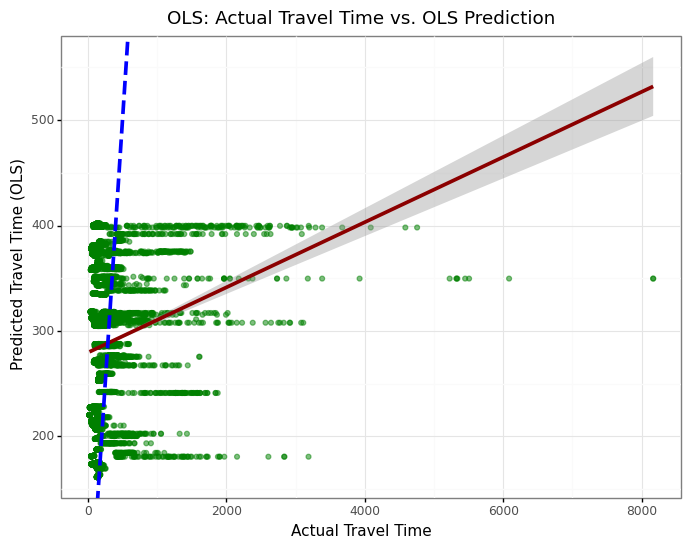

<ggplot: (313570311)>

In [10]:
# make the col for the OLS predicted values
MyTraffic.pol_df['pred_ols_2'] = ols_mod_2.predict()

# if predicted value is negative: force it to be zero
MyTraffic.pol_df['pred_ols_2'].loc[MyTraffic.pol_df['pred_ols_2'] < 0] = 0

(ggplot(MyTraffic.pol_df[['tr_time', 'pred_ols_2']], aes(x = 'tr_time', y = 'pred_ols_2'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'tr_time', y = 'pred_ols_2'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Time")
+ ylab("Predicted Travel Time (OLS)")
+ ggtitle("OLS: Actual Travel Time vs. OLS Prediction")
+ theme_bw())

### KNN

In [11]:
knn_fit_model_1 = knn(n_neighbors = 200).fit(X = MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']],
y = MyTraffic.pol_df['rou_speed'])

# create the column of predicted KNN values
MyTraffic.pol_df['pred_knn_1'] = knn_fit_model_1.predict(MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']])

# obtain score of fit
knn_fit_model_1.score(X = MyTraffic.pol_df[['names_code', 'boro_code', 'time_float', 'tr_time', 'tr_dist']], 
                  y = MyTraffic.pol_df['rou_speed'])

0.06294970617974116

In [12]:
# Use cross-validation instead of only one train-test split:

In [13]:
score_array = [cross_val_score(knn(n_neighbors = i), X = MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                           'time_float', 'tr_time', 'tr_dist']],
                               y = MyTraffic.pol_df['rou_speed'], cv = 5).mean() for i in range(0, 501, 1)]


In [14]:
cv_df = pd.DataFrame(score_array, columns = ['score'])
cv_df['num_neighbors'] = list(range(0, 501, 1))
# let us find the entry with the maximum cv score
# and the corresponding num_neighbors (K)
cv_df.loc[cv_df['score'] == cv_df['score'].max()]

,score,num_neighbors
6,0.269109,6


In [15]:
# Through experiment, I have found that the optimal value of K is 7

In [16]:
opt_knn_fit_model_1 = knn(n_neighbors = 7).fit(X = MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']],
y = MyTraffic.pol_df['rou_speed'])

# create the column of predicted KNN values
MyTraffic.pol_df['opt_pred_knn_1'] = opt_knn_fit_model_1.predict(MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']])

# obtain score of fit
opt_knn_fit_model_1.score(X = MyTraffic.pol_df[['names_code', 'boro_code', 'time_float', 'tr_time', 'tr_dist']], 
                  y = MyTraffic.pol_df['rou_speed'])

0.6230941642206309

In [17]:
MyTraffic.pol_df[['rou_speed', 'pred_knn_1', 'opt_pred_knn_1']].corr()

,rou_speed,pred_knn_1,opt_pred_knn_1
rou_speed,1.000000,0.256237,0.800447
pred_knn_1,0.256237,1.000000,0.363139
opt_pred_knn_1,0.800447,0.363139,1.000000


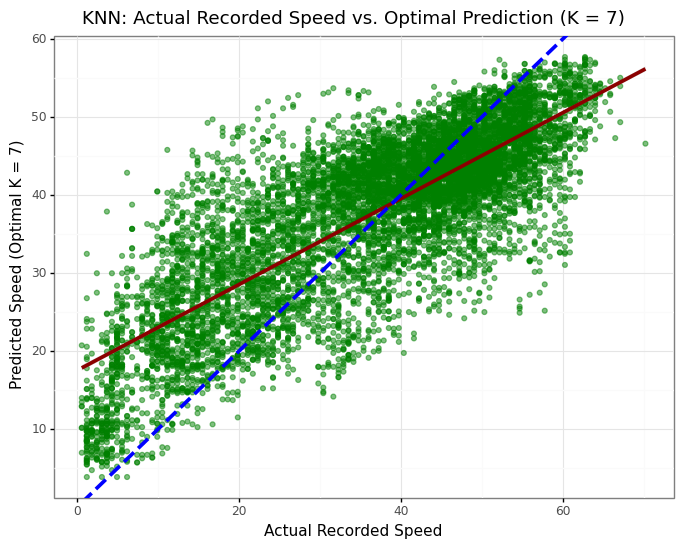

<ggplot: (313547807)>

In [18]:
(ggplot(MyTraffic.pol_df[['rou_speed', 'pred_knn_1', 'opt_pred_knn_1']], aes(x = 'rou_speed', y = 'opt_pred_knn_1'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'opt_pred_knn_1'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Recorded Speed")
+ ylab("Predicted Speed (Optimal K = 7)")
+ ggtitle("KNN: Actual Recorded Speed vs. Optimal Prediction (K = 7)")
+ theme_bw())

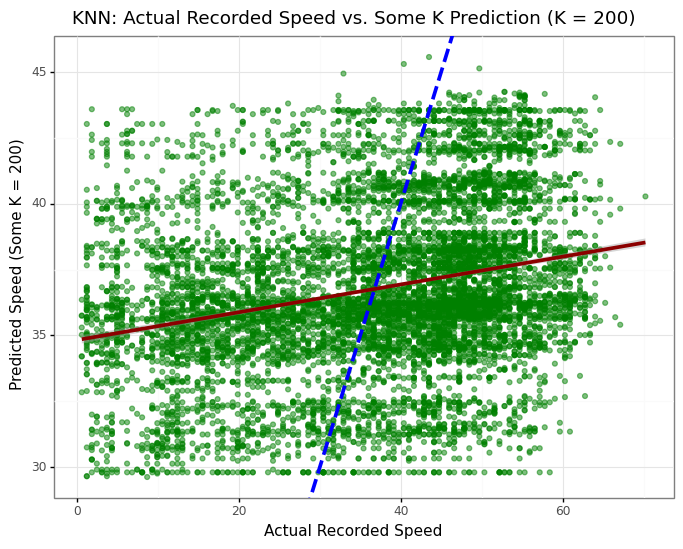

<ggplot: (313558122)>

In [19]:
(ggplot(MyTraffic.pol_df[['rou_speed', 'pred_knn_1', 'opt_pred_knn_1']], aes(x = 'rou_speed', y = 'pred_knn_1'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'pred_knn_1'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Recorded Speed")
+ ylab("Predicted Speed (Some K = 200)")
+ ggtitle("KNN: Actual Recorded Speed vs. Some K Prediction (K = 200)")
+ theme_bw())

In [20]:
# KNN Second model (trying to predict travel time)

In [21]:
score_array_knn_2 = [cross_val_score(knn(n_neighbors = i), X = MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                           'time_float', 'tr_dist']],
                               y = MyTraffic.pol_df['tr_time'], cv = 5).mean() for i in range(0, 501, 1)]


In [22]:
cv_df_2 = pd.DataFrame(score_array_knn_2, columns = ['score'])
cv_df_2['num_neighbors'] = list(range(0, 501, 1))
# let us find the entry with the maximum cv score
# and the corresponding num_neighbors (K)
cv_df_2.loc[cv_df['score'] == cv_df['score'].max()]

,score,num_neighbors
6,-0.132187,6


In [23]:
opt_knn_fit_model_2 = knn(n_neighbors = 7).fit(X = MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                     'time_float', 'tr_dist']],
y = MyTraffic.pol_df['tr_time'])

# create the column of predicted KNN values
MyTraffic.pol_df['opt_pred_knn_2'] = opt_knn_fit_model_2.predict(MyTraffic.pol_df[['names_code', 'boro_code',
                                                                                   'time_float', 'tr_dist']])

# obtain score of fit
opt_knn_fit_model_2.score(X = MyTraffic.pol_df[['names_code', 'boro_code', 'time_float', 'tr_dist']], 
                  y = MyTraffic.pol_df['tr_time'])

0.2080880195280952

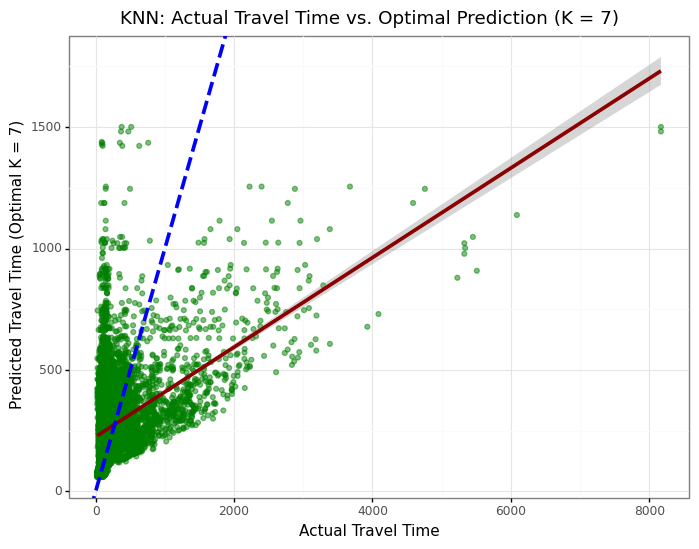

<ggplot: (313512596)>

In [24]:
(ggplot(MyTraffic.pol_df[['tr_time', 'opt_pred_knn_2']], aes(x = 'tr_time', y = 'opt_pred_knn_2'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'tr_time', y = 'opt_pred_knn_2'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Time")
+ ylab("Predicted Travel Time (Optimal K = 7)")
+ ggtitle("KNN: Actual Travel Time vs. Optimal Prediction (K = 7)")
+ theme_bw())

The Random Forests approach does not work as well, as the predicted value seems to stay constant for a range of various actual values.

In [25]:
# Random Forests
sklearn_rf = rf(n_estimators = 150, max_depth = 3).fit(MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']],
                                                       MyTraffic.pol_df['rou_speed'])

# create the column of predicted Random Forests values
MyTraffic.pol_df['pred_rf_1'] = sklearn_rf.predict(MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']])

# obtain the score of fitted model
sklearn_rf.score(MyTraffic.pol_df[['names_code', 'boro_code',
                                   'time_float', 'tr_time', 'tr_dist']], 
                 MyTraffic.pol_df['rou_speed'])

0.6792152866206069

In [26]:
# use Cross Validation to test for optimal hyper parameter

rf_score_arr = [cross_val_score(rf(n_estimators = j, max_depth = 3), 
                                MyTraffic.pol_df[['names_code', 'boro_code',
                                   'time_float', 'tr_time', 'tr_dist']], 
                                MyTraffic.pol_df['rou_speed'], cv = 5).mean() for j in range(100, 201, 1)]

In [27]:
rf_cv_df = pd.DataFrame(rf_score_arr, columns = ['rf_score'])
rf_cv_df['num_trees'] = list(range(100, 201, 1))
# let us find the entry with the maximum cv score
# and the corresponding num_trees (n_estimators)
rf_cv_df.loc[rf_cv_df['rf_score'] == rf_cv_df['rf_score'].max()]

,rf_score,num_trees
50,0.47618,150


In [28]:
opt_num = int(rf_cv_df.loc[rf_cv_df['rf_score'] == rf_cv_df['rf_score'].max()]["num_trees"])
print(opt_num)

150


In [29]:
# make the optimal n_estimators=opt_num prediction
opt_rf = rf(n_estimators = opt_num, max_depth = 3).fit(MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']],
                                                       MyTraffic.pol_df['rou_speed'])

MyTraffic.pol_df['opt_pred_rf_1'] = opt_rf.predict(MyTraffic.pol_df[['names_code', 'boro_code', 
                                                                   'time_float', 'tr_time', 'tr_dist']])


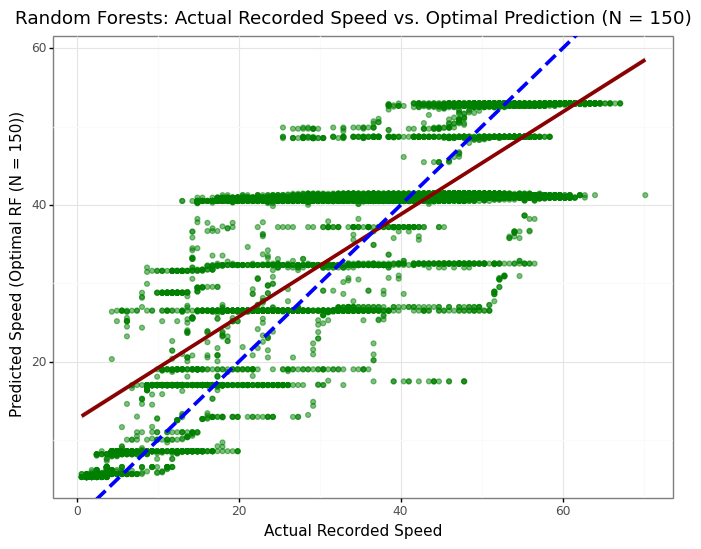

<ggplot: (313403329)>

In [30]:
(ggplot(MyTraffic.pol_df[['rou_speed', 'pred_rf_1', 'opt_pred_rf_1']], aes(x = 'rou_speed', y = 'opt_pred_rf_1'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'opt_pred_rf_1'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Recorded Speed")
+ ylab("Predicted Speed (Optimal RF (N = {}))".format(opt_num))
+ ggtitle("Random Forests: Actual Recorded Speed vs. Optimal Prediction (N = {})".format(opt_num))
+ theme_bw())

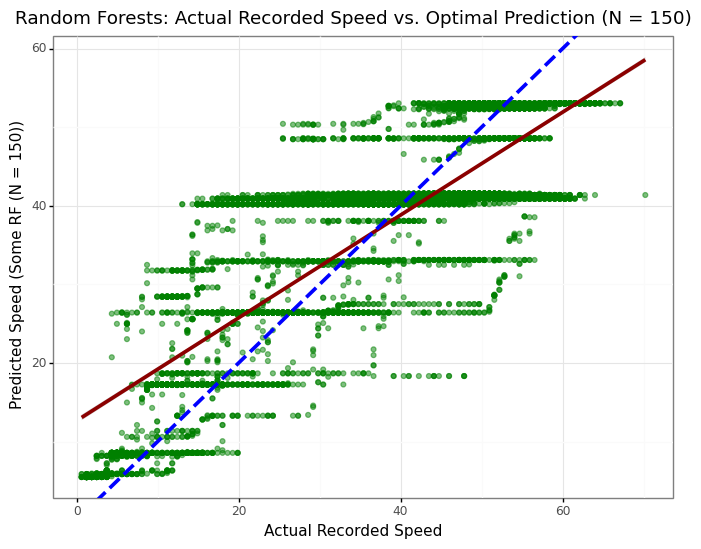

<ggplot: (313540855)>

In [31]:
(ggplot(MyTraffic.pol_df[['rou_speed', 'pred_rf_1', 'opt_pred_rf_1']], aes(x = 'rou_speed', y = 'pred_rf_1'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'pred_rf_1'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Recorded Speed")
+ ylab("Predicted Speed (Some RF (N = {}))".format("150"))
+ ggtitle("Random Forests: Actual Recorded Speed vs. Optimal Prediction (N = {})".format("150"))
+ theme_bw())

### Standardization of X-Variables and PCA (Principal Component Analysis) - Reduction of Dimension 

In [32]:
all_records = [] # container to keep track of all experimentations

In [33]:
all_records_second_step = [] # and for the second iteration - TRAVEL SPEED prediction

In [34]:
MyTraffic.pol_df

,names,rou_speed,time_s,boro,tr_time,geometry,names_code,boro_code,time_float,tr_dist,pred_ols_1,pred_ols_2,pred_knn_1,opt_pred_knn_1,opt_pred_knn_2,pred_rf_1,opt_pred_rf_1
0,11th ave n ganservoort - 12th ave @ 40th st,0.62,2021-12-04T14:33:10.000,Manhattan,4587.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638628e+12,0.021501,0.000000,398.159327,34.20815,12.957143,1187.571429,5.486044,5.304970
1,11th ave n ganservoort - 12th ave @ 40th st,0.62,2021-12-04T14:59:10.000,Manhattan,4757.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638630e+12,0.021501,0.000000,398.159734,35.75185,10.202857,1245.857143,5.486044,5.304970
2,11th ave n ganservoort - 12th ave @ 40th st,1.24,2021-12-04T11:23:10.000,Manhattan,2943.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638617e+12,0.021501,0.000000,398.156354,40.04225,10.645714,573.714286,5.486044,5.304970
3,11th ave n ganservoort - 12th ave @ 40th st,1.24,2021-12-04T12:08:11.000,Manhattan,2947.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638620e+12,0.021501,0.000000,398.157059,36.67790,6.031429,836.857143,5.486044,5.304970
4,11th ave n ganservoort - 12th ave @ 40th st,1.24,2021-12-04T12:38:11.000,Manhattan,3027.0,"LINESTRING (-74.00925 40.74047, -74.00893 40.7...",0,2,1.638621e+12,0.021501,0.000000,398.157528,36.46025,8.517143,932.428571,5.486044,5.304970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.19,2021-12-04T10:13:12.000,Queens,106.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638613e+12,0.011665,43.260103,172.007544,41.84435,51.834286,172.428571,41.528916,41.454977
9996,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.19,2021-12-04T10:23:10.000,Queens,105.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638613e+12,0.011665,43.281458,172.007700,42.01550,50.504286,156.857143,41.528916,41.454977
9997,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.19,2021-12-04T11:13:11.000,Queens,106.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638616e+12,0.011665,43.260174,172.008483,41.12040,51.570000,138.428571,41.528916,41.454977
9998,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,52.81,2021-12-04T10:03:11.000,Queens,105.0,"LINESTRING (-73.83345 40.77142, -73.83540 40.7...",124,3,1.638612e+12,0.011665,43.281434,172.007388,44.23675,51.391429,160.428571,41.528916,41.454977


<hr>

### KNN (Predicting Travel Time, and then Travel Speed)
- Original X variables
- Standardized X variables
- PCA - reduction of dimension

#### Predicting Travel Time

In [35]:
all_records.append(predict_model('KNN_TRtime', MyTraffic.pol_df, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist'],
                                'tr_time', 0, 501, 1, knn, 'KNN'))


The number of observations in the given DataFrame is: 9210
The valid number of observations left is: 9210

Using the KNN approach, the optimal hyperparameter is: 152 (within the range of (0,501,1).

And the optimal CV score is: -0.0776.

Using the KNN approach, based on a random train-test split (using random_state = 0):

The score, fitted on the train data, of the train data is: 0.011434;
The score, fitted on the train data, of the test data is: 0.009609.

------------------------------------------------------------------------------------------



In [36]:
MyTraffic.pol_df['pred_KNN_TRtime'] = all_records[0]['opt_regressor_obj'].\
predict(MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist']])

In [37]:
all_records[0]['opt_regressor_obj'].score(X = MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist']],
                                         y = MyTraffic.pol_df['tr_time'])

0.011036231868958524

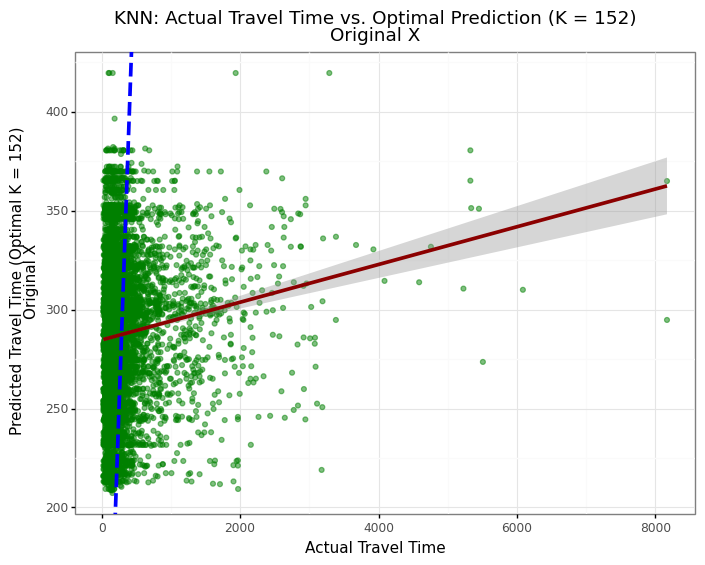

<ggplot: (313405525)>

In [38]:
temp_graph = (ggplot(MyTraffic.pol_df[['tr_time', 'pred_KNN_TRtime']], 
        aes(x = 'tr_time', y = 'pred_KNN_TRtime'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'tr_time', y = 'pred_KNN_TRtime'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Time")
+ ylab("Predicted Travel Time (Optimal K = {})\nOriginal X"\
       .format(all_records[0]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nOriginal X"\
          .format(all_records[0]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [39]:
temp_graph.save("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nOriginal X.PDF"\
          .format(all_records[0]['opt_hyperparam']))

#### Predicting Travel Speed

In [40]:
all_records_second_step.append(predict_model('KNN_TRspeed', MyTraffic.pol_df, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist', 'pred_KNN_TRtime'],
                                'rou_speed', 0, 501, 1, knn, 'KNN'))

The number of observations in the given DataFrame is: 9210
The valid number of observations left is: 9210



KeyboardInterrupt: 

In [ ]:
MyTraffic.pol_df['pred_KNN_TRspeed'] = all_records_second_step[0]['opt_regressor_obj'].\
predict(MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist', 'pred_KNN_TRtime']])

In [ ]:
all_records_second_step[0]['opt_regressor_obj'].\
score(X = MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist', 'pred_KNN_TRtime']],
y = MyTraffic.pol_df['rou_speed'])

In [ ]:
temp_graph = (ggplot(MyTraffic.pol_df[['rou_speed', 'pred_KNN_TRspeed']], 
        aes(x = 'rou_speed', y = 'pred_KNN_TRspeed'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'pred_KNN_TRspeed'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Speed")
+ ylab("Predicted Travel Speed (Optimal K = {})\nOriginal X"\
       .format(all_records_second_step[0]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nOriginal X"\
          .format(all_records_second_step[0]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
temp_graph.save("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nOriginal X.PDF"\
          .format(all_records_second_step[0]['opt_hyperparam']))

### Get rid of some outliers (<= 2000 seconds ~ 33 minutes of travel time)

#### Predicting Travel Time

In [ ]:
print("The percent of outliers, out of all observations, is {:.4f}%".format(
MyTraffic.pol_df[MyTraffic.pol_df['tr_time'] > 2000].shape[0] / MyTraffic.pol_df.shape[0] * 100))

In [ ]:
df_de_outlier = MyTraffic.pol_df[MyTraffic.pol_df['tr_time'] <= 2000]

In [ ]:
all_records.append(predict_model('NOOUT_KNN_TRtime', df_de_outlier, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist'],
                                'tr_time', 0, 501, 1, knn, 'KNN'))

In [ ]:
df_de_outlier['NOOUT_pred_KNN_TRtime'] = all_records[1]['opt_regressor_obj'].\
predict(df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist']])

In [ ]:
all_records[1]['opt_regressor_obj'].score(X = df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist']],
                                         y = df_de_outlier['tr_time'])

In [ ]:
temp_graph = (ggplot(df_de_outlier[['tr_time', 'NOOUT_pred_KNN_TRtime']], 
        aes(x = 'tr_time', y = 'NOOUT_pred_KNN_TRtime'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'tr_time', y = 'NOOUT_pred_KNN_TRtime'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Time")
+ ylab("Predicted Travel Time (Optimal K = {})\nOriginal X (Without Outliers)"\
       .format(all_records[1]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nOriginal X (Without Outliers)"\
          .format(all_records[1]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
temp_graph.save("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nOriginal X (Without Outliers).PDF"\
          .format(all_records[1]['opt_hyperparam']))

#### Predicting Travel Speed

In [ ]:
all_records_second_step.append(predict_model('NOOUT_KNN_TRspeed', df_de_outlier, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist', 'NOOUT_pred_KNN_TRtime'],
                                'rou_speed', 0, 501, 1, knn, 'KNN'))

In [ ]:
df_de_outlier['NOOUT_pred_KNN_TRspeed'] = all_records_second_step[1]['opt_regressor_obj'].\
predict(df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist', 'NOOUT_pred_KNN_TRtime']])

In [ ]:
all_records_second_step[1]['opt_regressor_obj']\
.score(X = df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist', 'NOOUT_pred_KNN_TRtime']],
y = df_de_outlier['rou_speed'])

In [ ]:
temp_graph = (ggplot(df_de_outlier[['rou_speed', 'NOOUT_pred_KNN_TRspeed']], 
        aes(x = 'rou_speed', y = 'NOOUT_pred_KNN_TRspeed'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'NOOUT_pred_KNN_TRspeed'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Speed")
+ ylab("Predicted Travel Speed (Optimal K = {})\nOriginal X (Without Outliers)"\
       .format(all_records_second_step[1]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nOriginal X (Without Outliers)"\
          .format(all_records_second_step[1]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
temp_graph.save("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nOriginal X (Without Outliers).PDF"\
          .format(all_records_second_step[1]['opt_hyperparam']))

### KNN - With Standardized X-Variables

#### Predicting Travel Time

In [ ]:
all_records.append(predict_model('st_KNN_TRtime', MyTraffic.pol_df, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist'],
                                'tr_time', 0, 501, 1, knn, 'KNN', standardize_X = True))

In [ ]:
X_VARS = StandardScaler().fit_transform(MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist']])

In [ ]:
MyTraffic.pol_df['st_pred_KNN_TRtime'] = all_records[2]['opt_regressor_obj'].predict(X_VARS)

In [ ]:
all_records[2]['opt_regressor_obj'].score(X = X_VARS, y = MyTraffic.pol_df['tr_time'])

In [ ]:
temp_graph = (ggplot(MyTraffic.pol_df[['tr_time', 'st_pred_KNN_TRtime']], 
        aes(x = 'tr_time', y = 'st_pred_KNN_TRtime'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'tr_time', y = 'st_pred_KNN_TRtime'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Time")
+ ylab("Predicted Travel Time (Optimal K = {})\nAfter Standardization of X"\
       .format(all_records[2]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nAfter Standardization of X"\
          .format(all_records[2]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
temp_graph.save("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nAfter Standardization of X.PDF"\
          .format(all_records[2]['opt_hyperparam']))

#### Predicting Travel Speed

In [ ]:
all_records_second_step.append(predict_model('st_KNN_TRspeed', MyTraffic.pol_df, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist', 'st_pred_KNN_TRtime'],
                                'rou_speed', 0, 501, 1, knn, 'KNN', standardize_X = True))

In [ ]:
X_VARS = StandardScaler().fit_transform(MyTraffic.pol_df[['names_code', 'boro_code',
                                                          'time_float', 'tr_dist', 'st_pred_KNN_TRtime']])

In [ ]:
MyTraffic.pol_df['st_pred_KNN_TRspeed'] = all_records_second_step[2]['opt_regressor_obj'].predict(X_VARS)

In [ ]:
all_records_second_step[2]['opt_regressor_obj'].score(X = X_VARS, y = MyTraffic.pol_df['rou_speed'])

In [ ]:
temp_graph = (ggplot(MyTraffic.pol_df[['rou_speed', 'st_pred_KNN_TRspeed']], 
        aes(x = 'rou_speed', y = 'st_pred_KNN_TRspeed'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'st_pred_KNN_TRspeed'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Speed")
+ ylab("Predicted Travel Speed (Optimal K = {})\nAfter Standardization of X"\
       .format(all_records_second_step[2]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nAfter Standardization of X"\
          .format(all_records_second_step[2]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
temp_graph.save("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nAfter Standardization of X.PDF"\
          .format(all_records_second_step[2]['opt_hyperparam']))

### KNN - With Standardized X-Variables, AND Drop Outliers

#### Predicting Travel Time

In [ ]:
all_records.append(predict_model('NOOUT_st_KNN_TRtime', df_de_outlier, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist'],
                                'tr_time', 0, 501, 1, knn, 'KNN', standardize_X = True))

In [ ]:
X_VARS = StandardScaler().fit_transform(df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist']])

In [ ]:
df_de_outlier['NOOUT_st_pred_KNN_TRtime'] = all_records[3]['opt_regressor_obj'].predict(X_VARS)

In [ ]:
all_records[3]['opt_regressor_obj'].score(X = X_VARS, y = df_de_outlier['tr_time'])

In [ ]:
temp_graph = (ggplot(df_de_outlier[['tr_time', 'NOOUT_st_pred_KNN_TRtime']], 
        aes(x = 'tr_time', y = 'NOOUT_st_pred_KNN_TRtime'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'tr_time', y = 'NOOUT_st_pred_KNN_TRtime'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Time")
+ ylab("Predicted Travel Time (Optimal K = {})\nAfter Standardization of X (Without Outliers)"\
       .format(all_records[3]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nAfter Standardization of X (Without Outliers)"\
          .format(all_records[3]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
temp_graph.save("KNN: Actual Travel Time vs. Optimal Prediction (K = {})\nAfter Standardization of X (Without Outliers).PDF"\
          .format(all_records[3]['opt_hyperparam']))

#### Predicting Travel Speed

In [ ]:
all_records_second_step.append(predict_model('NOOUT_st_KNN_TRspeed', df_de_outlier, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist', 'NOOUT_st_pred_KNN_TRtime'],
                                'rou_speed', 0, 501, 1, knn, 'KNN', standardize_X = True))

In [ ]:
X_VARS = StandardScaler().fit_transform(df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist', 'NOOUT_st_pred_KNN_TRtime']])

In [ ]:
df_de_outlier['NOOUT_st_pred_KNN_TRspeed'] = all_records_second_step[3]['opt_regressor_obj'].predict(X_VARS)

In [ ]:
all_records_second_step[3]['opt_regressor_obj'].score(X = X_VARS, y = df_de_outlier['rou_speed'])

In [ ]:
temp_graph = (ggplot(df_de_outlier[['rou_speed', 'NOOUT_st_pred_KNN_TRspeed']], 
        aes(x = 'rou_speed', y = 'NOOUT_st_pred_KNN_TRspeed'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'NOOUT_st_pred_KNN_TRspeed'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Speed")
+ ylab("Predicted Travel Speed (Optimal K = {})\nAfter Standardization of X (Without Outliers)"\
       .format(all_records_second_step[3]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nAfter Standardization of X (Without Outliers)"\
          .format(all_records_second_step[3]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
temp_graph.save("KNN: Actual Travel Speed vs. Optimal Prediction (K = {})\nAfter Standardization of X (Without Outliers).PDF"\
          .format(all_records_second_step[3]['opt_hyperparam']))

### PCA for the X-Variables in KNN
Note that PCA would always require standardization of the x-variables

### Original X

In [ ]:
# create df from updated overall record 
df = pd.DataFrame(all_records)
df.set_index(['model_approach', 'model_num'], inplace = True)
df

In [ ]:
df2 = pd.DataFrame(all_records_second_step)
df2.set_index(['model_approach', 'model_num'], inplace = True)
df2

<hr>

In [ ]:
df.sort_values(by = ['opt_cv_score', 'train_test_score'], ascending = False)

In [ ]:
df2.sort_values(by = ['opt_cv_score', 'train_test_score'], ascending = False)

In [ ]:
idx = 4
for var in [1, 0.95, 0.9, 0.85, 0.8, 0.75]:
    
    # Predict TRAVEL TIME first! 
    all_records.append(predict_model('PCA_{:.0f}%_TRtime'.format(var * 100), MyTraffic.pol_df, 
                        ['names_code', 'boro_code','time_float', 'tr_dist'],
                        'tr_time', 0, 1001, 1, knn, 'KNN', 
                        is_PCA = True, PCA_param = var))
    
    # transform x variables (standardize)
    X_vars_st = StandardScaler().fit_transform(\
    MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist']])
    
    X_VARS = PCA(var).fit(X_vars_st).transform(X_vars_st)
    
    # make predictions
    MyTraffic.pol_df['PCA_pred_KNN_TRtime_ind{}_var{}'.format(idx, var)] = \
    all_records[idx]['opt_regressor_obj'].predict(X_VARS)
    
    # get fit score
    print("The model fit score for travel time prediction is: {:.4f}\n"\
         .format(all_records[idx]['opt_regressor_obj'].\
                 score(X = X_VARS, y = MyTraffic.pol_df['tr_time'])))
    
    # Predict TRAVEL SPEED second! 
    all_records_second_step.append(predict_model('PCA_{:.0f}%_TRspeed'.format(var * 100), MyTraffic.pol_df, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist', 
                                  'PCA_pred_KNN_TRtime_ind{}_var{}'.format(idx, var)],
                                'rou_speed', 0, 1001, 1, knn, 'KNN', 
                                is_PCA = True, PCA_param = var))
    
    # transform x variables (standardize)
    X_vars_speed_st = StandardScaler().fit_transform(\
    MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist', 
    'PCA_pred_KNN_TRtime_ind{}_var{}'.format(idx, var)]])
    
    X_VARS_SPEED = PCA(var).fit(X_vars_speed_st).transform(X_vars_speed_st)
    
    # make predictions
    MyTraffic.pol_df['PCA_pred_KNN_TRspeed_ind{}_var{}'.format(idx, var)] = \
    all_records_second_step[idx]['opt_regressor_obj'].predict(X_VARS_SPEED)
    
    # get fit score
    print("The model fit score for travel speed prediction is: {:.4f}\n\n"\
         .format(all_records_second_step[idx]['opt_regressor_obj'].\
                 score(X = X_VARS_SPEED, y = MyTraffic.pol_df['rou_speed'])))
    
    idx += 1

### No Outliers

In [ ]:
idx = 4
for var in [1, 0.95, 0.9, 0.85, 0.8, 0.75]:
    
    # Predict TRAVEL TIME first! 
    all_records.append(predict_model('NOOUT_PCA_{:.0f}%_TRtime'.format(var * 100), df_de_outlier, 
                        ['names_code', 'boro_code','time_float', 'tr_dist'],
                        'tr_time', 0, 1001, 1, knn, 'KNN', 
                        is_PCA = True, PCA_param = var))
    
    # transform x variables (standardize)
    X_vars_st = StandardScaler().fit_transform(\
    df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist']])
    
    X_VARS = PCA(var).fit(X_vars_st).transform(X_vars_st)
    
    
    # make predictions
    df_de_outlier['NOOUT_PCA_pred_KNN_TRtime_ind{}_var{}'.format(idx, var)] = \
    all_records[idx]['opt_regressor_obj'].predict(X_VARS)
    
    # get fit score
    print("The model fit score for travel time prediction is: {:.4f}\n"\
         .format(all_records[idx]['opt_regressor_obj'].\
                 score(X = X_VARS, y = df_de_outlier['tr_time'])))
    
    # Predict TRAVEL SPEED second! 
    all_records_second_step.append(predict_model('NOOUT_PCA_{:.0f}%_TRspeed'.format(var * 100), df_de_outlier, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist', 
                                  'NOOUT_PCA_pred_KNN_TRtime_ind{}_var{}'.format(idx, var)],
                                'rou_speed', 0, 1001, 1, knn, 'KNN', 
                                is_PCA = True, PCA_param = var))
    
    # transform x variables (standardize)
    X_vars_speed_st = StandardScaler().fit_transform(\
    df_de_outlier[['names_code', 'boro_code','time_float', 'tr_dist', 
    'PCA_pred_KNN_TRtime_ind{}_var{}'.format(idx, var)]])
    
    X_VARS_SPEED = PCA(var).fit(X_vars_speed_st).transform(X_vars_speed_st)
    
    # make predictions
    MyTraffic.pol_df['NOOUT_PCA_pred_KNN_TRspeed_ind{}_var{}'.format(idx, var)] = \
    all_records_second_step[idx]['opt_regressor_obj'].predict(X_VARS_SPEED)
    
    # get fit score
    print("The model fit score for travel speed prediction is: {:.4f}\n\n"\
         .format(all_records_second_step[idx]['opt_regressor_obj'].\
                 score(X = X_VARS_SPEED, y = df_de_outlier['rou_speed'])))
    
    idx += 1

### Random Forests (Predicting Travel Time, and then Travel Speed)
- Original X variables
- Standardized X variables
- PCA - reduction of dimension

#### Predicting Travel Time

In [ ]:
all_records[7]

In [ ]:
all_records.append(predict_model('st_RF_TRtime', MyTraffic.pol_df, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist'],
                                'tr_time', 100, 201, 1, rf, 'RF', standardize_X = True))

In [ ]:
X_VARS = StandardScaler().fit_transform(MyTraffic.pol_df[['names_code', 'boro_code','time_float', 'tr_dist']])

In [ ]:
MyTraffic.pol_df['st_pred_RF_TRtime'] = all_records[7]['opt_regressor_obj'].predict(X_VARS)

In [ ]:
all_records[7]['opt_regressor_obj'].score(X = X_VARS, y = MyTraffic.pol_df['tr_time'])

In [ ]:
temp_graph = (ggplot(MyTraffic.pol_df[['tr_time', 'st_pred_RF_TRtime']], 
        aes(x = 'tr_time', y = 'st_pred_RF_TRtime'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'tr_time', y = 'st_pred_RF_TRtime'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Time")
+ ylab("Predicted Travel Time (Optimal No. Estimator = {})\nAfter Standardization of X (Without Outliers)"\
       .format(all_records[7]['opt_hyperparam']))
+ ggtitle("RF: Actual Travel Time vs. Optimal Prediction (No. Estimator = {})\nAfter Standardization of X (Without Outliers)"\
          .format(all_records[7]['opt_hyperparam']))
+ theme_bw())
temp_graph

#### Predicting Travel Speed

In [ ]:
all_records_second_step.append(predict_model('st_RF_TRspeed', MyTraffic.pol_df, 
                                 ['names_code', 'boro_code','time_float', 'tr_dist', 'st_pred_RF_TRtime'],
                                'rou_speed', 100, 201, 1, rf, 'RF', standardize_X = True))

In [ ]:
X_VARS = StandardScaler().fit_transform(MyTraffic.pol_df[['names_code', 'boro_code',
                                                          'time_float', 'tr_dist', 'st_pred_RF_TRtime']])

In [ ]:
MyTraffic.pol_df['st_pred_KNN_TRspeed'] = all_records_second_step[4]['opt_regressor_obj'].predict(X_VARS)

In [ ]:
all_records_second_step[4]['opt_regressor_obj'].score(X = X_VARS, y = MyTraffic.pol_df['rou_speed'])

In [ ]:
temp_graph = (ggplot(MyTraffic.pol_df[['rou_speed', 'st_pred_KNN_TRspeed']], 
        aes(x = 'rou_speed', y = 'st_pred_KNN_TRspeed'))
+ geom_point(color = 'green', alpha = 0.5)
+ geom_smooth(aes(x = 'rou_speed', y = 'st_pred_KNN_TRspeed'), color = 'darkred', size = 1.5)
+ geom_abline(linetype = 'dashed', color = 'blue', size = 1.5)
+ xlab("Actual Travel Speed")
+ ylab("Predicted Travel Speed (Optimal No. Estimator = {})\nAfter Standardization of X"\
       .format(all_records_second_step[4]['opt_hyperparam']))
+ ggtitle("KNN: Actual Travel Speed vs. Optimal Prediction (No. Estimator = {})\nAfter Standardization of X"\
          .format(all_records_second_step[4]['opt_hyperparam']))
+ theme_bw())
temp_graph

In [ ]:
predict_model(model_num, df, var_labels, y_label, min_param,
                 max_param, inc_param, regressor_obj, approach_name,
                 num_cv = 5, is_PCA = False, PCA_param = 1.0):

In [ ]:
some_df['pred_rou_speed'] = predictor_obj_2.predict(some_df[['names_code', 'boro_code',
                                                                     'time_float', 'pred_tr_time', 'tr_dist']])